# Experiments

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid

## Setup

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [21]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [22]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = exp.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="test_balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
def get_results_df():
    return pd.DataFrame(exp.exp_results)

In [24]:
def print_prettier_exp_results(exp_name):
    ba_df = get_results_df()[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=["balanced_accuracy_mean"], ascending=False)

## Load Dataset

In [25]:
gm_df = gm.load_game_matchup_dataset()

## Experiments

### Setup

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [33]:
exp_prefix = ""
exp_group_name = "experiments"
results_total = []
exp.exp_results = []
exp_X_columns = model_config.X_candidate_features
exp_y_columns = model_config.y_candidate_features

#exp.exp_results = utils.deserialize_object(exp_group_name)

### Dataset

El paramatero max_split de la clase TimeSeriesSplit permite dividir el dataset por cantidad de filas, por lo que vamos a escoger solo las temporadas que tienen la misma cantidad de partidos.


In [28]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [29]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [30]:
# tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=1230)
# X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
# print(len(X))
# for train_index, test_index in tscv.split(X=X):
#     print("dtype: ", type(train_index))
#     print("TRAIN:", train_index, "TEST:", test_index)

### Algorithms 

In [31]:
models = exp.get_models()

### Create Season Time Series Split

In [32]:
sscv = utils.SeasonSeriesSplit(df)

### Experiment using 1 season

In [34]:
experiment_name = f"{exp_prefix}1_season"

In [35]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 1_season
Done


In [36]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
1,1_season,SVM,0.700944,0.023601
4,1_season,XGB,0.675954,0.025712
5,1_season,LGB,0.674175,0.019576
0,1_season,KNN,0.671224,0.015085
2,1_season,RF,0.670915,0.021095
3,1_season,GB,0.592331,0.024007


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

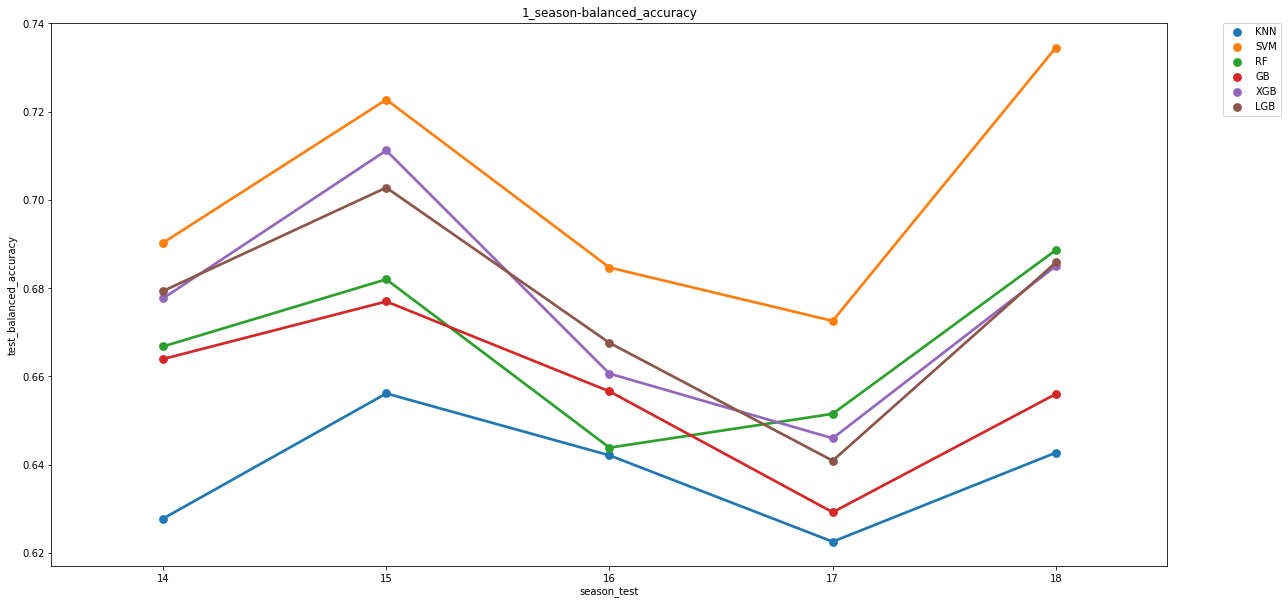

In [32]:
#### Visualize experiments results
#results_df = exp.plot_experiment_results(experiment_name, results)
#results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - SVM supero con gran ventaja a los demas algoritmos. El algoritmo XGB fue ell que mas cerca estuvo a SVM.
    - Se evidencian los siguientes patrones:
        - Para todos los algoritmos hubo una notable mejoria al ser entrenados con la temporada 2014 para predecir la temporada 2015.
        - Sin embargo en las siguientes validaciones para la temporada 2016 y 2017 nuevamente se evidencia una caida en el rendimiento de todos los algoritmos.
        - Para predecir la temporada 2018 pues este rendimiento mejoro.

### Experiment using StandardScaler

In [33]:
experiment_name = f"{exp_prefix}scaled_data"

In [34]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, True)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment scaled_data
Done


In [35]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
4,scaled_data,XGB,0.678358,0.022872
52,scaled_data,XGB,0.678358,0.022872
0,scaled_data,KNN,0.675430,0.019288
48,scaled_data,KNN,0.675430,0.019288
5,scaled_data,LGB,0.675349,0.022620
53,scaled_data,LGB,0.675349,0.022620
2,scaled_data,RF,0.672158,0.017384
50,scaled_data,RF,0.672158,0.017384
3,scaled_data,GB,0.660082,0.023645
51,scaled_data,GB,0.660082,0.023645


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***KNN***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

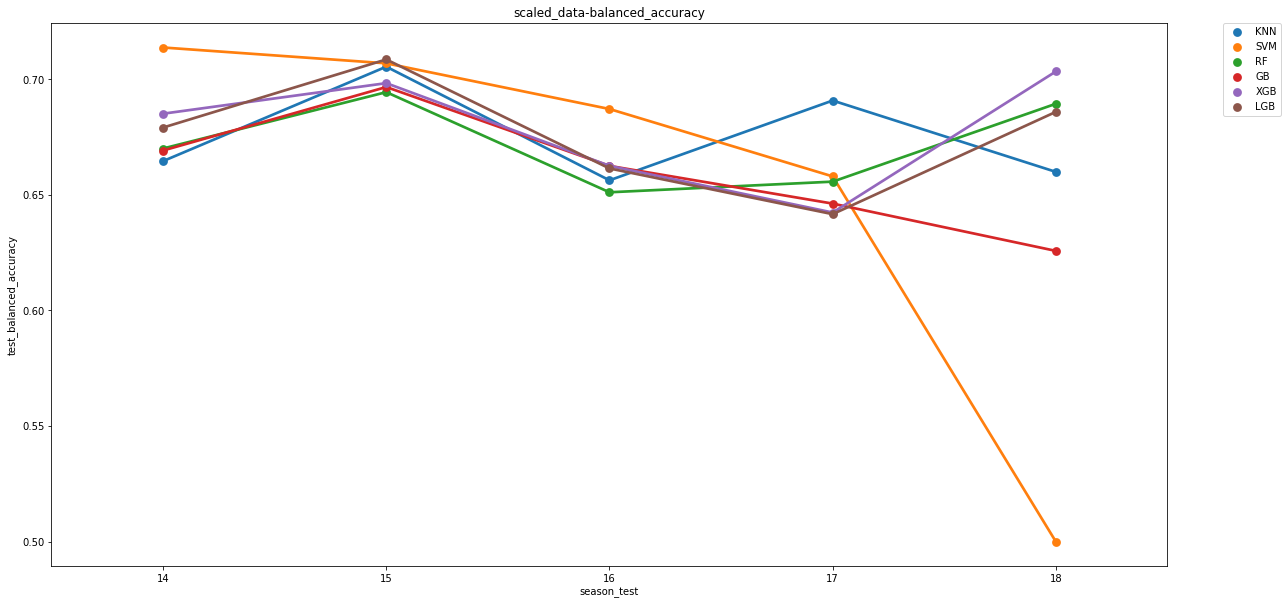

In [36]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment: train: 2s; test: 1s

In [37]:
experiment_name = f"{exp_prefix}2_seasons"

In [38]:
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 2_seasons
Done


In [39]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
7,2_seasons,SVM,0.711381,0.016598
55,2_seasons,SVM,0.711381,0.016598
11,2_seasons,LGB,0.682565,0.016205
59,2_seasons,LGB,0.682565,0.016205
10,2_seasons,XGB,0.680809,0.023497
58,2_seasons,XGB,0.680809,0.023497
9,2_seasons,GB,0.677578,0.015123
57,2_seasons,GB,0.677578,0.015123
8,2_seasons,RF,0.669988,0.009696
56,2_seasons,RF,0.669988,0.009696


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

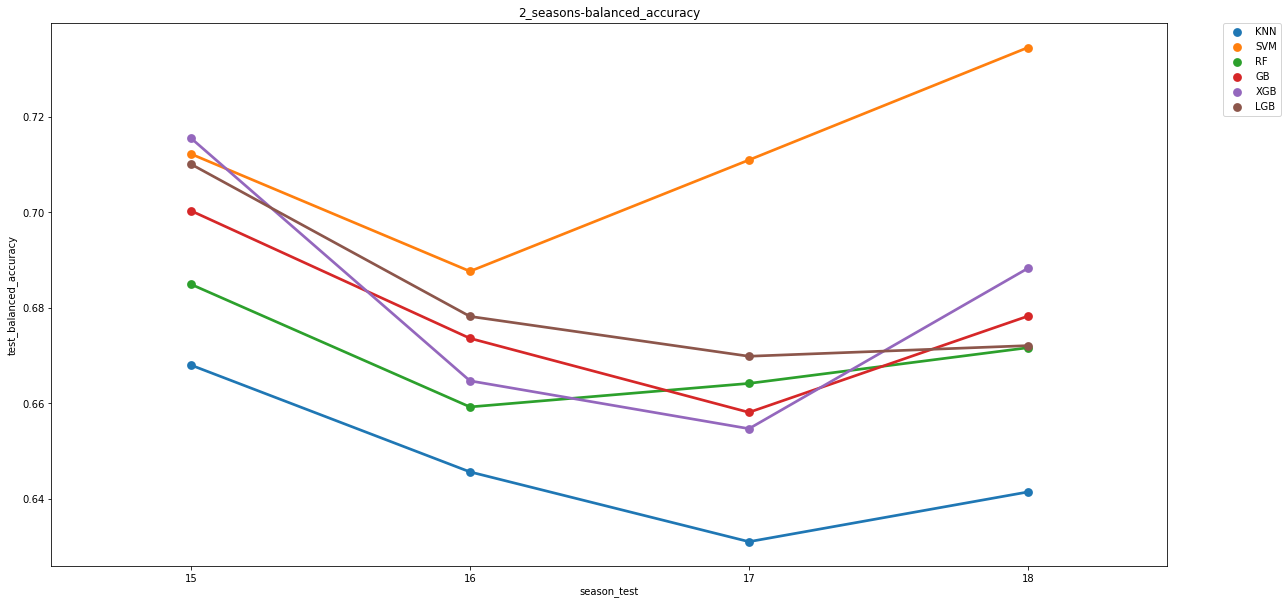

In [40]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - Claramente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un patron en el que todos los algoritmos tuvieron una caida de su rendimiento en la temporada 16 y continuo cayendo en el 17, a excepcion de RF que mejoro.
    - Otro patron que se evidencia es que para la temporada 2018 todos los algoritmos mejoraron.
    

### Experiment: train: 3s; test: 1s

In [41]:
experiment_name = f"{exp_prefix}3_seasons"

In [42]:
folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3_seasons
Done


In [43]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
13,3_seasons,SVM,0.710814,0.013518
61,3_seasons,SVM,0.710814,0.013518
17,3_seasons,LGB,0.683067,0.006457
65,3_seasons,LGB,0.683067,0.006457
16,3_seasons,XGB,0.678936,0.006787
64,3_seasons,XGB,0.678936,0.006787
15,3_seasons,GB,0.677799,0.011340
63,3_seasons,GB,0.677799,0.011340
14,3_seasons,RF,0.671573,0.010919
62,3_seasons,RF,0.671573,0.010919


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.
    
 Se destaca tambien que estos resultados son muy similares a los del experimento anterior(2s 1s)

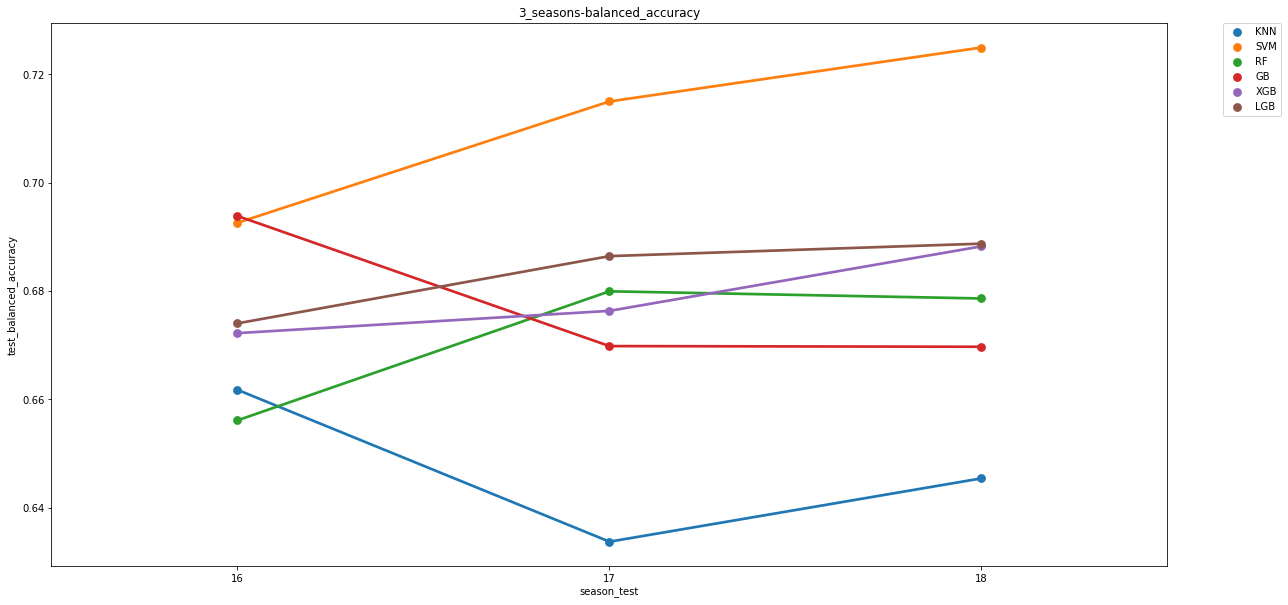

In [44]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Nuevamente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un ligero patron de ascenso para los tres algoritmos con mejor rendimiento, lo cual indica cierta estabilidad en las validaciones de este experimento comparada con los experimentos anteriores.
    - Tambien se evidencia que comparado con los experimentos anteriores, en este el peor rendimiento estuvo en la primera validacion la del 16.

### Experiment train: 3q ; test: 1q

In [45]:
experiment_name = f"{exp_prefix}3q_1q"

In [46]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3q_1q
Done


In [47]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
19,3q_1q,SVM,0.663372,0.078508
67,3q_1q,SVM,0.663372,0.078508
23,3q_1q,LGB,0.660360,0.039866
71,3q_1q,LGB,0.660360,0.039866
20,3q_1q,RF,0.658867,0.036463
68,3q_1q,RF,0.658867,0.036463
22,3q_1q,XGB,0.655548,0.037270
70,3q_1q,XGB,0.655548,0.037270
21,3q_1q,GB,0.645044,0.032274
69,3q_1q,GB,0.645044,0.032274


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***RF***: Obtuvo el tercer promedio mas alto.
    
 Comparado con el anterior experimento(3s 1s), estos resultados son peores, pero es importante destacar que se hicieron muchisimas mas validaciones que los experimentos anteriores. Ver grafico debajo.

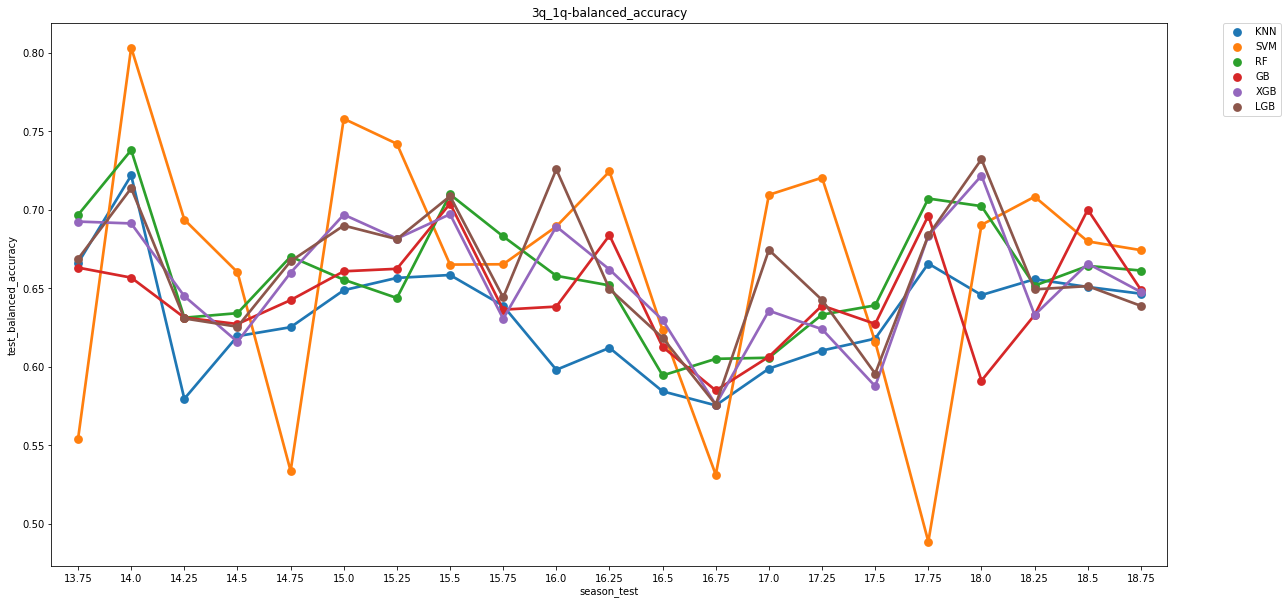

In [48]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue bastante inestable, tuvo casi igual de picos de buenos rendimientos como caidas de malos rendientos.
    - Se observa un patron, en cada cuarto de temporada 0.25, que corresponde a la mitad(desde 0.25 a 0.5) pues el rendimiento de cada algoritmo tuvo una caida.

### Experiment train: 4q ; test: 2q

In [49]:
experiment_name = f"{exp_prefix}4q_2q"

In [50]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 4q_2q
Done


In [51]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
25,4q_2q,SVM,0.702563,0.042494
73,4q_2q,SVM,0.702563,0.042494
28,4q_2q,XGB,0.674543,0.032952
76,4q_2q,XGB,0.674543,0.032952
29,4q_2q,LGB,0.670770,0.034637
77,4q_2q,LGB,0.670770,0.034637
26,4q_2q,RF,0.664553,0.026312
74,4q_2q,RF,0.664553,0.026312
27,4q_2q,GB,0.663385,0.031729
75,4q_2q,GB,0.663385,0.031729


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.


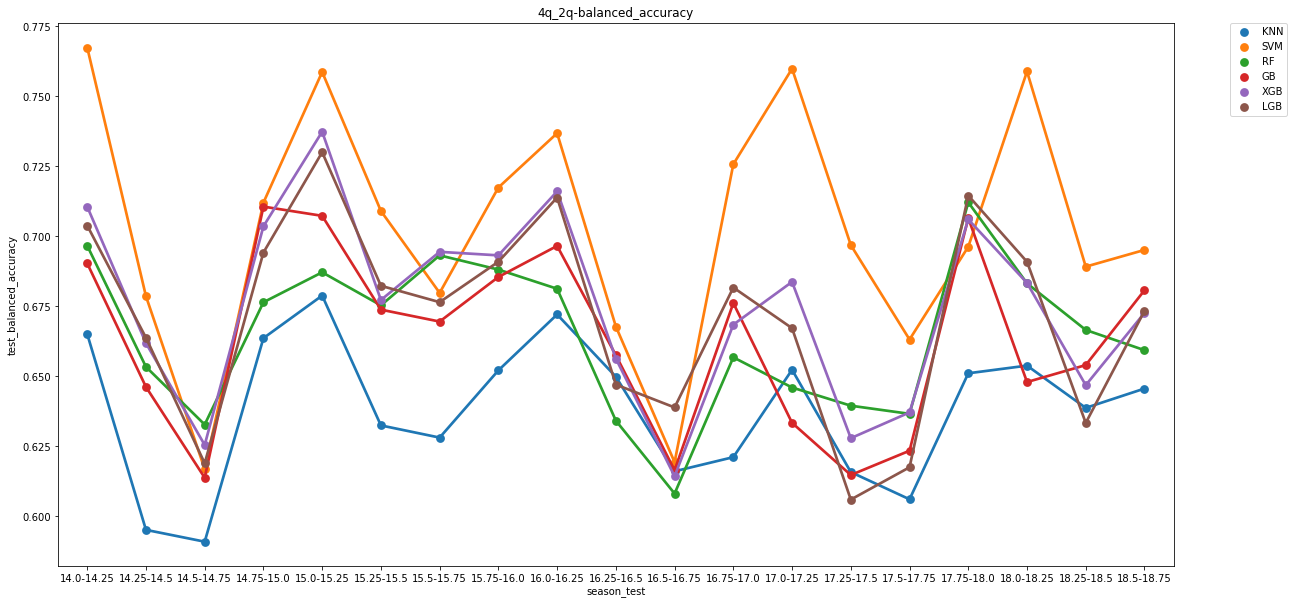

In [52]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue un poco mas estable que el experimento anterior.
    - Se observa un patron, en cada validacion 0.5-0.75, es decir, que se trata de predecir la segunda mitad de la temporada, usando la primera mitad de la temporada actual y la ultima mitad de la anterior, pues hay una caida en el rendimiento de los algoritmos.

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [53]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [54]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment r1q_2q_1q
Done


In [55]:
print_prettier_exp_results(experiment_name)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
31,r1q_2q_1q,SVM,0.688324,0.057657
34,r1q_2q_1q,XGB,0.668087,0.040989
35,r1q_2q_1q,LGB,0.663861,0.044758
32,r1q_2q_1q,RF,0.659227,0.031778
33,r1q_2q_1q,GB,0.657835,0.033663
80,r1q_2q_1q,RF,0.650746,0.039269
38,r1q_2q_1q,RF,0.650746,0.039269
37,r1q_2q_1q,SVM,0.641917,0.075410
79,r1q_2q_1q,SVM,0.641917,0.075410
82,r1q_2q_1q,XGB,0.641808,0.039616


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.


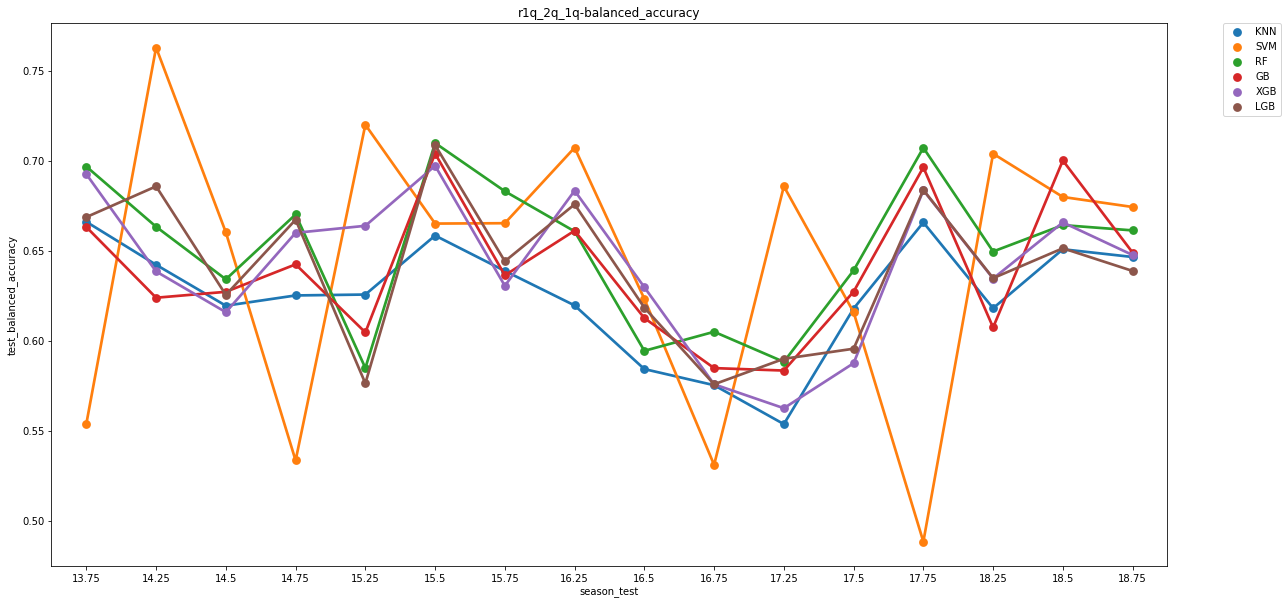

In [56]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Se observa un patron, en cada validacion .75, es decir, que se trata de predecir el ultimo cuarto de temporada, pues hay una caida del rendimiento en el caso del algoritmo SVM, sin embargo no es lo mismo para los otros algoritmos, al menos no para todos las validaciones .75.

## Experiments comparison

In [57]:
utils.serialize_object(exp_group_name, exp.exp_results)

In [58]:
exp_df = get_results_df()

In [59]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [60]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [61]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,2_seasons,SVM,0.711381,0.016598
1,2_seasons,SVM,0.711381,0.016598
2,3_seasons,SVM,0.710814,0.013518
3,3_seasons,SVM,0.710814,0.013518
4,4q_2q,SVM,0.702563,0.042494
5,4q_2q,SVM,0.702563,0.042494


Basado en la metrica 'balanced_accuracy_mean' se observa:

- El algoritmo SVM obtuvo el mejor rendimiento para la mayoria de los experimentos. LGB fue el algoritmo siguiente que obtuvo el mejor rendimiento. 
- En los experimentos que se obtuvo el mejor rendimiento fueron usando 2 y 3 temporadas para entrenamiento para predecir al siguiente.
    

## Plot experiment results

In [83]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Tuning model

A partir de los experimentos y basado en las observaciones realizadas trabajaremos de ahora en adelante solo con los modelos: SVM y LGB.

Para el entrenamiento cada modelo utilizaremos las variantes:

- Train: 2 seasons ; Test: 1 season ; Ventana deslizante de: 1 season
- Train: 3 seasons ; Test: 1 season ; Ventana deslizante de: 1 season